100%|██████████| 1003/1003 [00:01<00:00, 786.10it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 8, 50)               │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 8, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,451 (200.98 KB)

 Trainable params: 51,451 (200.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.3968 - val_loss: 0.0929
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0099 - val_loss: 0.0557
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0062 - val_loss: 0.0342
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 0.0195
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

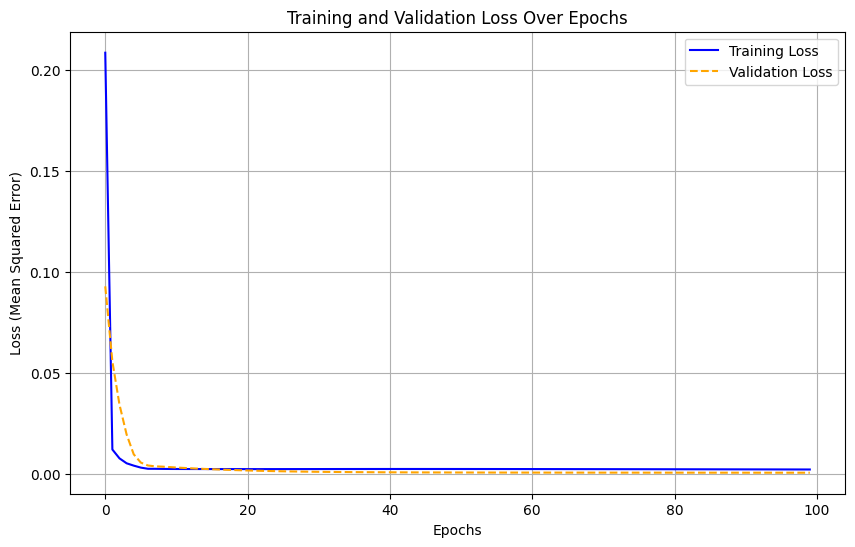

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5540e-04 


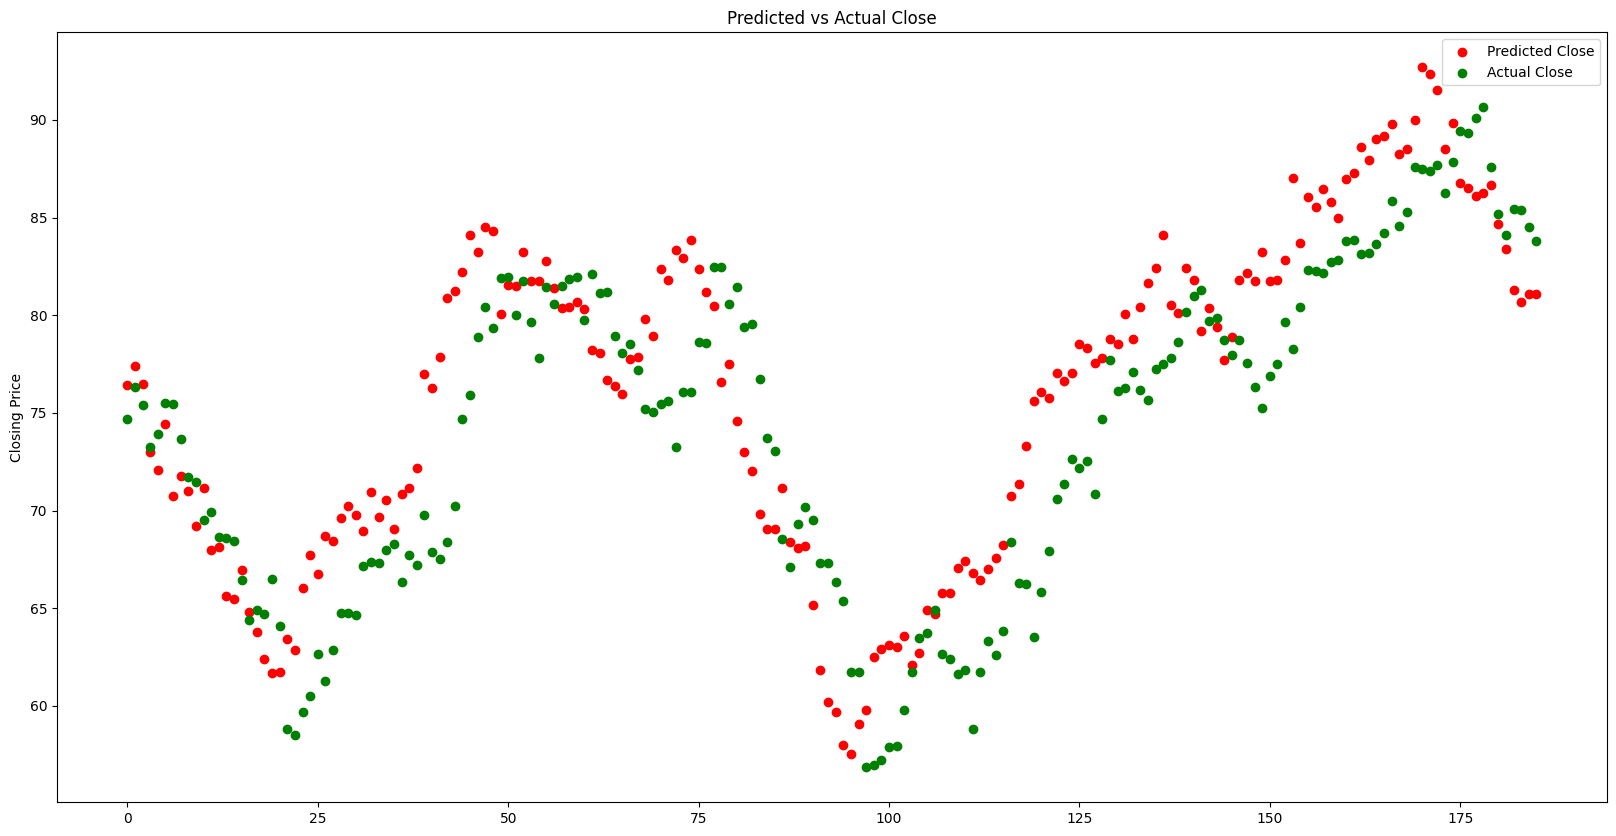

In [ ]:
# Install yfinance
!pip install yfinance

# Importing necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Keras model imports
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Transformers model imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model for FinBERT (financial sentiment analysis)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Input data processing
import torch.nn.functional as F

def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

data1 = pd.read_csv('dataset.csv', index_col=0)
data1 = data1.dropna(subset=["stock"]).reset_index(drop=True)
data1.rename(columns={'stock': 'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x: x.split()[0])
data1.drop_duplicates(subset='title', keep='first', inplace=True)

data = data1

data["ticker"].value_counts()

# Processing data for a specific ticker
tickerSymbol = "BABA"
tmpData = {}
for i in tqdm(data[data['ticker'] == tickerSymbol]['date'].unique()):
    tmpData[i] = data.loc[(data['ticker'] == tickerSymbol) & (data['date'] == i)]['title'].tolist()

ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg = sentimentArr[0]
    negAvg = sentimentArr[1]
    neuAvg = sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu': neuAvg}

dateSentimentGroups = {}
for i in tqdm(tmpData):
    scores = findPercentageBySentences(tmpData[i])
    dateSentimentGroups[i] = scores

data = []
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
hist_ri = hist.reset_index()

window_size = 8

for i in tqdm(dateSentimentGroups):
    start = i
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    index = hist_ri[hist_ri["Date"] == i].index
    try:
        prevDay = hist.iloc[(index - window_size)[0]: index[0]]
        nextDay = hist.loc[nextDay]
        data.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg']] + list(prevDay['Close']) + [nextDay['Close']])
    except:
        pass

df = pd.DataFrame(columns=['numArticles', 'neutral', 'positive', 'negative', 'Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8', 'Close'], data=data)

# LSTM as backbone (with sentiment analysis)
X = df[['neutral', 'positive', 'negative', 'Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8']]
y = df['Close']

n_timesteps = 8
close_cols = ['Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8']
close_data = df[close_cols].values
n_samples = close_data.shape[0]
close_data = close_data.reshape(n_samples, n_timesteps)

target = df['Close'].values

scaler = MinMaxScaler(feature_range=(0, 1))
rdata = scaler.fit_transform(np.concatenate([close_data, target.reshape(-1, 1)], axis=1))

X_rdata = rdata[:, :n_timesteps]
y = rdata[:, n_timesteps:]

sentiment_cols = ['neutral', 'positive', 'negative']
sentiment_data = df[sentiment_cols].values

n_features = len(sentiment_cols) + 1
X = np.zeros((n_samples, n_timesteps, n_features))
for i in range(n_timesteps):
    X[:, i, :len(sentiment_cols)] = sentiment_data
    X[:, i, len(sentiment_cols):] = X_rdata[:, i: (i + 1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

window_size = n_timesteps

def build_and_compile_model_LSTM():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1 + len(sentiment_cols))))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam())
    return model

LSTM_model = build_and_compile_model_LSTM()
LSTM_model.summary()

history = LSTM_model.fit(X_train, y_train, validation_split=0.2, shuffle=False, epochs=100)

# Function to plot loss during training
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot training and validation loss
plot_loss(history)

preds = LSTM_model.predict(X_test)

LSTM_model.evaluate(X_test, y_test, verbose=1)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
X = [i for i in range(len(preds))]

y = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:, :], preds], axis=1))[:, -1:]
z = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:, :], y_test], axis=1))[:, -1:]

plt.scatter(X, y, color='r', label='Predicted Close')
plt.scatter(X, z, color='g', label='Actual Close')
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")
plt.legend()
plt.show()


with sentiment analysis


100%|██████████| 1003/1003 [00:01<00:00, 769.72it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 50)               │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,451 (200.98 KB)

 Trainable params: 51,451 (200.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.3817 - val_loss: 0.0947
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0213 - val_loss: 0.0952
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - val_loss: 0.0522
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0074 - val_loss: 0.0262
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

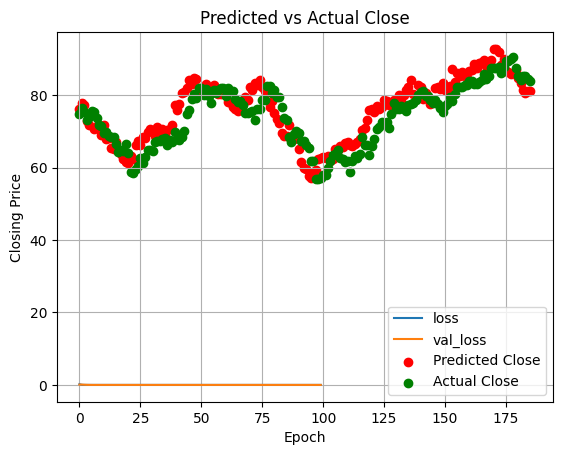

In [ ]:
# Install yfinance
!pip install yfinance

# Importing necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Keras model imports
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Transformers model imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model for FinBERT (financial sentiment analysis)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Input data processing
import torch.nn.functional as F

def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

data1 = pd.read_csv('dataset.csv', index_col=0)
data1 = data1.dropna(subset=["stock"]).reset_index(drop=True)
data1.rename(columns={'stock': 'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x: x.split()[0])
data1.drop_duplicates(subset='title', keep='first', inplace=True)

data = data1

data["ticker"].value_counts()

# Processing data for a specific ticker
tickerSymbol = "BABA"
tmpData = {}
for i in tqdm(data[data['ticker'] == tickerSymbol]['date'].unique()):
    tmpData[i] = data.loc[(data['ticker'] == tickerSymbol) & (data['date'] == i)]['title'].tolist()

ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg = sentimentArr[0]
    negAvg = sentimentArr[1]
    neuAvg = sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu': neuAvg}

dateSentimentGroups = {}
for i in tqdm(tmpData):
    scores = findPercentageBySentences(tmpData[i])
    dateSentimentGroups[i] = scores

data = []
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
hist_ri = hist.reset_index()

window_size = 8

for i in tqdm(dateSentimentGroups):
    start = i
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    index = hist_ri[hist_ri["Date"] == i].index
    try:
        prevDay = hist.iloc[(index - window_size)[0]: index[0]]
        nextDay = hist.loc[nextDay]
        data.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg']] + list(prevDay['Close']) + [nextDay['Close']])
    except:
        pass

df = pd.DataFrame(columns=['numArticles', 'neutral', 'positive', 'negative', 'Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8', 'Close'], data=data)

# LSTM as backbone (with sentiment analysis)
X = df[['neutral', 'positive', 'negative', 'Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8']]
y = df['Close']

n_timesteps = 8
close_cols = ['Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8']
close_data = df[close_cols].values
n_samples = close_data.shape[0]
close_data = close_data.reshape(n_samples, n_timesteps)

target = df['Close'].values

scaler = MinMaxScaler(feature_range=(0, 1))
rdata = scaler.fit_transform(np.concatenate([close_data, target.reshape(-1, 1)], axis=1))

X_rdata = rdata[:, :n_timesteps]
y = rdata[:, n_timesteps:]

sentiment_cols = ['neutral', 'positive', 'negative']
sentiment_data = df[sentiment_cols].values

n_features = len(sentiment_cols) + 1
X = np.zeros((n_samples, n_timesteps, n_features))
for i in range(n_timesteps):
    X[:, i, :len(sentiment_cols)] = sentiment_data
    X[:, i, len(sentiment_cols):] = X_rdata[:, i: (i + 1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

window_size = n_timesteps

def build_and_compile_model_LSTM():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1 + len(sentiment_cols))))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam())
    return model

LSTM_model = build_and_compile_model_LSTM()
LSTM_model.summary()

history = LSTM_model.fit(X_train, y_train, validation_split=0.2, shuffle=False, epochs=100)

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Closing Price]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

preds = LSTM_model.predict(X_test)

# Evaluate and calculate metrics
y_test_actual = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:, :], y_test], axis=1))[:, -1:]
y_pred_actual = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:, :], preds], axis=1))[:, -1:]

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

print(f"Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting predicted vs actual closing prices
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
X = [i for i in range(len(preds))]

plt.scatter(X, y_pred_actual, color='r', label='Predicted Close')
plt.scatter(X, y_test_actual, color='g', label='Actual Close')
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")
plt.legend()
plt.grid(True)
plt.show()
